# Load Omega Point & SGQLC Packages

* **OMEGAPOINT** open source wrapper to Omega Point GraphQL API developed in conjunction with our customers https://github.com/RossFabricant/omegapoint.
* **SGQLC** Python wrapper for GraphQL used by the omegapoint open source library: https://github.com/profusion/sgqlc

In [1]:
!pip install omegapoint
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement request (from omegapoint) (from versions: none)
ERROR: No matching distribution found for request (from omegapoint)


Defaulting to user installation because normal site-packages is not writeable


# Variables & Helper Functions

A combination of functions that
* Generate the user input forms
* Process the input data from the forms
* Run the regression and output the results in a table & graph

In [2]:
from omegapoint import schema, utils, omegapoint as op 
import pandas as pd
import datetime
from datetime import date
import numpy as np
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output, HTML
import requests
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import io
from pandas.io.json import  json_normalize
import json
import functools

#This script expects 3 enviroment variables to exist: 
#op.DEFAULT_MODEL_ID = os.getenv('OMEGA_POINT_DEFAULT_MODEL_ID')
#op.API_KEY = os.getenv('OMEGA_POINT_API_KEY')
#op.URL = os.getenv('OMEGA_POINT_URL')
#If you don't want to set enviromnet variables you can set these 3 variable explicitly.

form_map ={}


def build_predictor_dataset(start,end,sedols,model,fname): 
    dfs = [] 
    dates = op.utils.weekdays(start, end)
    dates = [d for d in dates]
    for i in range(len(dates)-1):
        try:
            dfs.append(op.get_security_search(dates[i], dates[i+1], sedols, ['ticker','sedol'], ['Profit'], model))
        except:
            print( 'Fail '+dates[i].strftime('%Y-%m-%d'))
    df = pd.concat(dfs)
    df['prev_Profit'] = df.groupby(['ticker','sedol'],as_index=False)['Profit'].shift(1)
    df = df[df['prev_Profit']==df['prev_Profit']]
    df['Profit_delta'] = abs(df['Profit']-df['prev_Profit'])
    df = df[df['Profit_delta']>1]
    df[['date','sedol','Profit_delta']].to_csv('%s' % fname, index=False)
    print ("saved predictor dataset to %s" % fname)
    return df


def get_watchlist_securities(watchlist_id):
    oper = op.OpOperation(schema.Query)
    sec = (
        oper.watchlist(id=watchlist_id)
        .equities()
        .id()      
    )
    sec.__fields__("sedol")   
    res = oper()
    return [r.id.sedol for r in res.watchlist.equities]

def regression_calculation(indep,dep,weights):  
    indep = sm.add_constant(indep)
    est = sm.WLS(dep, indep,weights=weights).fit()
    return est

def calc_regression(df,predictor_column):    
    myresults =[]
    cols = [c for c in list(df) if 'mkt' in c or 'total' in c or 'specific' in c]
    for c in cols:
        tempdf = df[['sqrt_adv',c,predictor_column]].dropna()
        weights = tempdf['sqrt_adv']
        indep = tempdf[predictor_column]
        dep = tempdf[c]
        try:
            results = regressionCalculation(indep,dep,weights)
            myresults.append([c,results.params[1],results.tvalues[1]])
        except:
            pass
    return pd.DataFrame(myresults,columns = ['Return_Column','Regression_Beta','Regression_TStat'])

def create_combo_chart(df,title,xlabel = 'Horizon',y1label = 'Betas',y2lablel = 'TStats',xcol = 'Return_Column',
                     y1col = 'Regression_Beta',y2col = 'Regression_TStat'):
    fig, ax1 = plt.subplots(figsize=(10,6))
    color = 'tab:red'
    #line plot creation
    ax1.set_title(title, fontsize=16)
    ax1.set_xlabel(xlabel, fontsize=16)
    ax1.set_ylabel(y1label, fontsize=16)
    ax1 = sns.lineplot(x=xcol, y=y1col, data = df, sort=False, color=color)
    ax1.tick_params(axis='y')
    #specify we want to share the same x-axis
    ax2 = ax1.twinx()
    #bar plot creation
    ax2.set_ylabel(y2lablel, fontsize=16)

    ax2 = sns.barplot(x=xcol, y=y2col, data = df,  palette='summer')
    ax2.tick_params(axis='y', color=color)
    #show plot
    plt.show()

def createComboChart(df,title,xlabel = 'Horizon',y1label = 'Betas',y2lablel = 'TStats',xcol = 'Return_Column',y1col = 'Regression_Beta',y2col = 'Regression_TStat'):
    fig, ax1 = plt.subplots(figsize=(10,6))
    color = 'tab:red'
    #line plot creation
    ax1.set_title(title, fontsize=16)
    ax1.set_xlabel(xlabel, fontsize=16)
    ax1.set_ylabel(y1label, fontsize=16)
    ax1 = sns.lineplot(x=xcol, y=y1col, data = df, sort=False, color=color)
    ax1.tick_params(axis='y')
    #specify we want to share the same x-axis
    ax2 = ax1.twinx()
    #bar plot creation
    ax2.set_ylabel(y2lablel, fontsize=16)

    ax2 = sns.barplot(x=xcol, y=y2col, data = df,  palette='summer')
    ax2.tick_params(axis='y', color=color)
    #show plot
    plt.show()
    
def plot_regressions(df):
    rets = ['total_return','mkt_adj_return','specific']
    for ret in rets:
        tempdf = df[df['Return_Column'].str.contains(ret)]
        tempdf['Return_Column'] = tempdf['Return_Column'].apply(lambda x: int(x.split('_')[-1].replace('d','')))
        tempdf = tempdf.sort_values('Return_Column')
        tempdf['Return_Column'] = tempdf['Return_Column'].apply(lambda x: str(x)+'d')  
        createComboChart(tempdf,ret+' regression results')

def display_run_regression_form(form):
    display(        
        form['Return path'],
        form['Predictor path'],
        form['Predictor column'],

        form['button_regression'],
        form['button_clear'],

        form['output']
        )
    
def render_run_regression_form(form):
    style = {'description_width': 'initial'}
    form['Predictor path'] = widgets.Text(style=style,description='*location of predictor dataset', 
                                          value=r'c:\temp\predictors.csv' ,layout=Layout(width='50%'))
    form['Return path'] = widgets.Text(style=style,description='*location of return dataset', 
                                       value=r'c:\temp\returns.csv' ,layout=Layout(width='50%'))
    form['Predictor column'] = widgets.Text(style=style,description='*predictor column name',
                                            value='Profit_delta' ,layout=Layout(width='50%'))

    form['button_clear'] = widgets.Button(description="Clear Regression Output Below")
    form['button_regression'] = widgets.Button(description="Show regression analysis")
    form['output'] = widgets.Output()

    form['button_clear'].on_click(on_button_clear_clicked)
    form['button_regression'].on_click(on_button_regression_clicked)
    form['tag'] = 'run_regression'
    form_map['Clear Regression Output Below'] = form
    form_map['Show regression analysis'] = form
    display_run_regression_form(form)

    return form

def display_form(form):
    display(
        form['token'],        
        form['model'],
#        form['account'],
        form['start_date'],
        form['end_date'],
        form['wid'],
        form['R3KWatchlist'],        
        form['Return path'],
        form['Predictor path'],
        form['Predictor column'],
        form['button'],
        form['button_upload'],
        form['button_clear'],
        form['button_r3k'],
        form['button_predictor'],        
        form['button_regression'],
        form['output']
        )
    
def render_form(form):
    style = {'description_width': 'initial'}
    form['model'] = widgets.Text(description='*Model ID', value=op.DEFAULT_MODEL_ID)
    form['start_date'] = widgets.Text(description='*YYYYMMDD', value='20200102')
    form['end_date'] = widgets.Text(description='*YYYYMMDD', value='20200110')
    form['wid'] = widgets.Text(description='*WatchlistID', value='f1a58f8c-9c75-4da7-af1c-d64cd1390d2d',layout=Layout(width='50%'))
    form['R3KWatchlist'] = widgets.Text(style=style,description='*R3K watchlist name', value='R3K')
    form['Predictor path'] = widgets.Text(style=style,description='*location of predictor dataset', value='./predictor_dataset_r3k.csv' ,layout=Layout(width='50%'))
    form['Return path'] = widgets.Text(style=style,description='*location of return dataset', value='./r3k_analysis.csv' ,layout=Layout(width='50%'))
    form['Predictor column'] = widgets.Text(style=style,description='*predictor column name', value='Profit_delta' ,layout=Layout(width='50%'))

    form['button'] = widgets.Button(description="Generate Returns File")
    form['button_clear'] = widgets.Button(description="Clear Output Below")
    form['button_upload'] = widgets.Button(description="Upload files")
    form['button_regression'] = widgets.Button(description="Show regression analysis")
    form['output'] = widgets.Output()
    form['button_r3k'] = widgets.Button(description="Generate R3K watchlist")
    form['button_predictor'] = widgets.Button(description="buildPredictorDataset")

    form['button'].on_click(on_button_clicked) 
    form['button_upload'].on_click(on_button_upload_clicked)   
    form['button_clear'].on_click(on_button_clear_clicked)
    form['button_r3k'].on_click(on_button_r3k_clicked)
    form['button_predictor'].on_click(on_button_predictor_clicked)
    form['button_regression'].on_click(on_button_regression_clicked)
    
    display_form(form)

    return form

def display_generate_watchlist_form(form):
    display(
        form['model'],
        form['start_date'],
        form['end_date'],
        form['R3KWatchlist'],     
        form['button_r3k'],
        form['output']
        )
    
def render_generate_watchlist_form(form):
    style = {'description_width': 'initial'}
    models = [m.id for m in op.get_models()]
    form['model'] = widgets.Combobox(
        placeholder=models[0],
        options=models,
        description='Model:',
        ensure_option=True)
    form['start_date'] = widgets.Text(description='*YYYYMMDD', value='20200102')
    form['end_date'] = widgets.Text(description='*YYYYMMDD', value='20200110')
    form['R3KWatchlist'] = widgets.Text(style=style,description='*R3K watchlist name', value='R3K')
    form['output'] = widgets.Output()
    form['button_r3k'] = widgets.Button(description="Generate R3K watchlist")

    form['button_r3k'].on_click(on_button_r3k_clicked)
    form['tag'] = 'generate_watchlist'
    form_map['Generate R3K watchlist'] = form
    display_generate_watchlist_form(form)

    return form


def display_generate_predictors_form(form):
    display(
        form['model'],
        form['start_date'],
        form['end_date'],
        form['wid'],
        form['File Name'],

        form['button_predictor'],
        form['button_clear'],
        form['output']
        )

def render_generate_predictors_form(form):
    style = {'description_width': 'initial'}

    form['output'] = widgets.Output()

    models = [m.id for m in op.get_models()]
    form['model'] = widgets.Combobox(
        placeholder=models[0],
        options=models,
        description='Model:',
        ensure_option=True)

    form['start_date'] = widgets.Text(description='*YYYYMMDD', value='20200102')
    form['end_date'] = widgets.Text(description='*YYYYMMDD', value='20200619')
    form['wid'] = widgets.Text(description='*Watchlist', value='R3K',layout=Layout(width='50%'))
    form['File Name'] = widgets.Text(description='*File Name', value=r'c:\temp\predictors.csv',layout=Layout(width='50%'))
    
    form['button_predictor'] = widgets.Button(description="buildPredictorDataset")
    form['button_clear'] = widgets.Button(description="Clear Predictor Output Below")

    form['button_predictor'].on_click(on_button_predictor_clicked)
    form['button_clear'].on_click(on_button_clear_clicked)
    form['tag'] = 'generate_predictors'
    form_map['buildPredictorDataset'] = form
    form_map['Clear Predictor Output Below'] = form
    display_generate_predictors_form(form)

    return form

def display_generate_returns_form(form):
    display(
        form['model'],
#        form['account'],
        form['start_date'],
        form['end_date'],
        form['wid'],
        form['File Name'],

        form['button'],
        form['button_clear'],
        form['output']
        )

def render_generate_returns_form(form):
    style = {'description_width': 'initial'}
    models = [m.id for m in op.get_models()]
    form['model'] = widgets.Combobox(
        placeholder=models[0],
        options=models,
        description='Model:',
        ensure_option=True)
    form['start_date'] = widgets.Text(description='*YYYYMMDD', value='20200102')
    form['end_date'] = widgets.Text(description='*YYYYMMDD', value='20200619')
    form['wid'] = widgets.Text(description='*Watchlist', value='R3K',layout=Layout(width='50%'))
    form['File Name'] = widgets.Text(description='*File Name', value=r'C:\temp\returns.csv',layout=Layout(width='50%'))
    form['button'] = widgets.Button(description="Generate Returns File")
    form['button_clear'] = widgets.Button(description="Clear Returns Output Below")
    form['output'] = widgets.Output()

    form['button'].on_click(on_button_clicked) 
    form['button_clear'].on_click(on_button_clear_clicked)
    form['tag'] = 'generate_returns'
    form_map['Generate Returns File'] = form
    form_map['Clear Returns Output Below'] = form
    display_generate_returns_form(form)

    return form

def on_button_clicked(b):
    form = form_map[b.description]
    with form['output']:
        print('== Running ==')
        df =run(form)
        print('== Finished ==')
        df

def on_button_upload_clicked(b):
    uploaded = files.upload()

def on_button_clear_clicked(b):
    form = form_map[b.description]
    form['output'] = widgets.Output()
    clear_output()
    if form['tag'] == 'generate_returns':
        render_generate_returns_form(form)
    elif form['tag'] == 'generate_predictors':
        display_generate_predictors_form(form)
    elif form['tag'] == 'generate_watchlist':    
        display_generate_watchlist_form(form)
    elif form['tag'] == 'run_regression':
        display_run_regression_form(form)
    else:
        display_form(form)

def on_button_r3k_clicked(b):
    form = form_map[b.description]
    print ("running")
    name = form['R3KWatchlist'].value
    print (name)
    start_date = form['start_date'].value
    start_date = datetime.datetime.strptime(start_date,"%Y%m%d").date()
    end_date = form['end_date'].value
    end_date = datetime.datetime.strptime(end_date,"%Y%m%d").date()
    model_id = form['model'].value
    generate_r3k_watchlist(start_date,end_date,name,model_id)
    print("R3K Watchlist created")
    
def generate_r3k_watchlist(start_date, end_date, name, model_id):
    if model_id is None or model_id == '': model_id = op.DEFAULT_MODEL_ID
    dates = [d for d in utils.weekdays(start_date, end_date) if not (d.month == 1 and d.day == 1)]
    months = set((d.year, d.month) for d in dates)
    fom = []
    for m in months:
        for d in dates: 
            if d.year == m[0] and d.month == m[1]:
                fom.append(d)
                break
    try:
        wid = op.get_watchlist_id(name)
    except:
        op.create_watchlist(name)
    op.clear_watchlist_securities(name)
    sedols =[]
    for dt in sorted(fom):
        print(f'Loading R3K sedols for {dt}')
        df = op.etf_security_search(dt, dt, "IWV.ARCX", ['sedol'], [], model_id)
        sedols += df.sedol.to_list()
    sedols = set(sedols)
    op.add_watchlist_securities(name, 'sedol', sedols)

def on_button_predictor_clicked(b):
    form = form_map[b.description]
    start_date = form['start_date'].value
    start_date = datetime.datetime.strptime(start_date,"%Y%m%d").date()
    end_date = form['end_date'].value
    end_date = datetime.datetime.strptime(end_date,"%Y%m%d").date()
    model_id = form['model'].value
    if model_id is None or model_id == '': model_id = op.DEFAULT_MODEL_ID
    wid = form['wid'].value
    fname = form['File Name'].value
    sedols = get_watchlist_sedols(wid)
    build_predictor_dataset(start_date,end_date,sedols,model_id,fname)

def calc_regression(df,predictor_column):    
    myresults =[]
    cols = [c for c in list(df) if 'mkt' in c or 'total' in c or 'specific' in c]
    for c in cols:
        tempdf = df[['sqrt_adv',c,predictor_column]].dropna()
        weights = tempdf['sqrt_adv']
        indep = tempdf[predictor_column]
        dep = tempdf[c]
        try:
            results = regressionCalculation(indep,dep,weights)
            myresults.append([c,results.params[1],results.tvalues[1]])
        except:
            pass
    return pd.DataFrame(myresults,columns = ['Return_Column','Regression_Beta','Regression_TStat'])

def regressionCalculation(indep,dep,weights):  
    indep = sm.add_constant(indep)
    est = sm.WLS(dep, indep,weights=weights).fit()
    return est

def on_button_regression_clicked(b):
    form = form_map[b.description]
    pred_path = form['Predictor path'].value   
    ret_path =   form['Return path'].value 
    predictordf = pd.read_csv(pred_path)
    predictor_column  = form['Predictor column'].value 
   
    df=  pd.read_csv(ret_path)
    df = df.merge(predictordf,on=['date','sedol'])
    
    print('printing merged data to ./pre_regression_data.csv)')
    df.to_csv('./pre_regression_data.csv',index=False)

    regressiondf = calc_regression(df,predictor_column)
    print('printing regression results to ./regression_results.csv)')
    regressiondf.to_csv('./regression_results.csv',index=False)
    plot_regressions(regressiondf) 
    
def get_watchlist_sedols(watchlist):
    oper = op.OpOperation(schema.Query)
    oper.watchlist(id=watchlist).equities.id.sedol()
    return [w.id.sedol for w in oper().watchlist.equities if w.id is not None and w.id.sedol is not None]


def run(form): 
    model_id = form['model'].value
    if model_id is None or model_id == '': model_id = op.DEFAULT_MODEL_ID
    start_date = form['start_date'].value
    start_date = datetime.datetime.strptime(start_date,"%Y%m%d").date()
    end_date = form['end_date'].value
    end_date = datetime.datetime.strptime(end_date,"%Y%m%d").date()
    wid = form['wid'].value
    fname = form['File Name'].value
    
    sedols = get_watchlist_sedols(wid)
    horizons = [-2, -1, 0, 1, 2, 3, 5, 10, 21, 42, 63]
    security_columns = ['average_daily_volume']
    factors = ['Profit', 'Growth']
    dates = utils.weekdays(start_date, end_date)
    print('Getting total, specific, sector and factor summary returns')
    stockdf_rets =[]
    for i in range(len(sedols)):
        sedol = sedols[i]
        print("%s) %s" %(i,sedol))
        try:
            stockdf_rets.append(op.get_stock_returns(id_type = 'sedol', ids = [sedol], start_date = start_date, 
                                                     end_date = end_date,model_id=model_id))
        except:
            pass
    stockdf_ret = pd.concat(stockdf_rets)
    print('Getting market sensitivity returns')
    df_factor_ret = op.get_stock_factor_returns(id_type = 'sedol', ids = sedols, start_date = start_date,
                                                end_date = end_date, factor_cols = ['MarketSens'],
                                                model_id = model_id)
    df_ret = stockdf_ret.merge(df_factor_ret)
    df_ret['mkt_adj_return'] = df_ret.total_return - df_ret.MarketSens
    print('Converting cumulative returns to daily returns at different time horizons.')
    return_columns = []
    for days in horizons:
        col_name = f'mkt_adj_return_{days}d'
        df_ret[col_name] = op.get_daily_total_return(df_ret, col_name = 'mkt_adj_return', days_forward = days)
        return_columns.append(col_name)
        col_name = f'total_return_{days}d'
        df_ret[col_name] = op.get_daily_total_return(df_ret, col_name = 'total_return', days_forward = days)
        return_columns.append(col_name)
        col_name = f'specific_{days}d'
        #Note that there's a different function for handling factor returns versus total returns.
        df_ret[col_name] = op.get_daily_factor_return(df_ret, factor_col = 'specific_return', days_forward = days)
        return_columns.append(col_name)
    print('Get security data from security search, for each date.')
    dates = op.utils.weekdays(start_date, end_date)
    dates = [d for d in dates if d.month != 1 or d.day !=1]
    df_searchs =[]
    for i in range(len(dates)-1):
        try:
            df_searchs.append(op.get_security_search(dates[i], dates[i], sedols, security_columns, 
                                                     factors,model_id = model_id))
        except:
            pass

    df_search= pd.concat(df_searchs)
    
    df_search['sqrt_adv'] = np.sqrt(df_search.average_daily_volume)
    
    df =df_ret.merge(df_search)[['date','sedol', 'sqrt_adv', 'Growth', 'Profit'] + return_columns]
    df.head()
    df.to_csv(r'%s' % fname, index=False)
    print('Wrote output to %s' % fname)
    

    return df


# Generate Universe

We utilitize two omegapoint API functions to generate an r3k-based universe for our return dataset:

* **Security Search** we can search the entire model universe or any index, ETF, or portfolio we have loaded in the platform via the UI (https://support.ompnt.com/en/articles/2966118-security-search) or API https://support.ompnt.com/en/articles/3117192-security-search-api

* **Watchlist** We can save any list of securities to a static watchlist via the UI (https://support.ompnt.com/en/articles/2966106-watchlists) or API (https://support.ompnt.com/en/articles/2785725-api-watchlists)


To query the Omega Point API, we need
* **API Token**
* **Model ID** 
* **Account ID**

To generate a search across time, we need
* **Start Date**
* **End Date** 

To save our output to a static watchlist, we need to enter in 
* **R3K watchlist name**

In [3]:
form_generate_watchlist = render_generate_watchlist_form({})

Combobox(value='', description='Model:', ensure_option=True, options=('AXWW4-MH', 'AXWW4-SH', 'QES-US'), place…

Text(value='20200102', description='*YYYYMMDD')

Text(value='20200110', description='*YYYYMMDD')

Text(value='R3K', description='*R3K watchlist name', style=DescriptionStyle(description_width='initial'))

Button(description='Generate R3K watchlist', style=ButtonStyle())

Output()

# Generate Historical Returns

In [4]:
form_generate_returns = render_generate_returns_form({})

Combobox(value='', description='Model:', ensure_option=True, options=('AXWW4-MH', 'AXWW4-SH', 'QES-US'), place…

Text(value='20200102', description='*YYYYMMDD')

Text(value='20200619', description='*YYYYMMDD')

Text(value='R3K', description='*Watchlist', layout=Layout(width='50%'))

Text(value='C:\\temp\\returns.csv', description='*File Name', layout=Layout(width='50%'))

Button(description='Generate Returns File', style=ButtonStyle())

Button(description='Clear Returns Output Below', style=ButtonStyle())

Output()

In [25]:
quick_ret = pd.read_csv(r"C:\temp\returns.csv")
quick_ret.head()

,date,sedol,sqrt_adv,Growth,Profit,mkt_adj_return_-2d,total_return_-2d,specific_-2d,mkt_adj_return_-1d,total_return_-1d,...,specific_10d,mkt_adj_return_21d,total_return_21d,specific_21d,mkt_adj_return_42d,total_return_42d,specific_42d,mkt_adj_return_63d,total_return_63d,specific_63d
0,2020-01-02,BF950B1,4213.810627,-0.425287,0.530398,NaN,NaN,NaN,NaN,NaN,...,0.034920,0.006119,0.005061,0.007508,-0.008064,-0.010628,0.055652,-0.059491,-0.062247,0.201974
1,2020-01-03,BF950B1,4168.416966,-0.425543,0.529833,NaN,NaN,NaN,0.008615,0.008530,...,0.018133,0.022647,0.021826,0.008447,-0.028132,-0.031360,0.057469,-0.164553,-0.173805,0.143336
2,2020-01-06,BF950B1,3994.821648,-0.425318,0.532491,-0.005257,-0.005342,-0.006095,-0.013993,-0.013991,...,0.035642,0.032669,0.032307,0.007653,0.043436,0.039939,0.104224,-0.119353,-0.128612,0.184391
3,2020-01-07,BF950B1,3327.416415,-0.426632,0.532964,-0.014248,-0.014249,-0.013575,-0.000252,-0.000255,...,-0.003982,0.056353,0.056234,0.017513,0.014837,0.010433,0.109593,-0.137361,-0.148935,0.186170
4,2020-01-08,BF950B1,3298.060036,-0.427640,0.532394,0.011321,0.011318,0.010476,0.011570,0.011569,...,-0.011944,0.041090,0.040996,0.010073,0.030799,0.025402,0.143175,-0.065805,-0.069430,0.188897


# Build Sample Predictor Dataset

In [23]:
form_predictor = render_generate_predictors_form({})

Combobox(value='', description='Model:', ensure_option=True, options=('AXWW4-MH', 'AXWW4-SH', 'QES-US'), place…

Text(value='20200102', description='*YYYYMMDD')

Text(value='20200619', description='*YYYYMMDD')

Text(value='R3K', description='*Watchlist', layout=Layout(width='50%'))

Text(value='c:\\temp\\predictors.csv', description='*File Name', layout=Layout(width='50%'))

Button(description='buildPredictorDataset', style=ButtonStyle())

Button(description='Clear Predictor Output Below', style=ButtonStyle())

Output()

2020-01-02
2020-01-03
2020-01-03
2020-01-06
2020-01-06
2020-01-07
2020-01-07
2020-01-08
2020-01-08
2020-01-09
2020-01-09
2020-01-10
2020-01-10
2020-01-13
2020-01-13
2020-01-14
2020-01-14
2020-01-15
2020-01-15
2020-01-16
2020-01-16
2020-01-17
2020-01-17
2020-01-20
2020-01-20
2020-01-21
2020-01-21
2020-01-22
2020-01-22
2020-01-23
2020-01-23
2020-01-24
2020-01-24
2020-01-27
2020-01-27
2020-01-28
2020-01-28
2020-01-29
2020-01-29
2020-01-30
2020-01-30
2020-01-31
2020-01-31
2020-02-03
2020-02-03
2020-02-04
2020-02-04
2020-02-05
2020-02-05
2020-02-06
2020-02-06
2020-02-07
2020-02-07
2020-02-10
2020-02-10
2020-02-11
2020-02-11
2020-02-12
2020-02-12
2020-02-13
2020-02-13
2020-02-14
2020-02-14
2020-02-17
2020-02-17
2020-02-18
2020-02-18
2020-02-19
2020-02-19
2020-02-20
2020-02-20
2020-02-21
2020-02-21
2020-02-24
2020-02-24
2020-02-25
2020-02-25
2020-02-26
2020-02-26
2020-02-27
2020-02-27
2020-02-28
2020-02-28
2020-03-02
2020-03-02
2020-03-03
2020-03-03
2020-03-04
2020-03-04
2020-03-05
2020-03-05

In [24]:
quick_pred = pd.read_csv(r"c:\temp\predictors.csv")
quick_pred.head()

,date,sedol,Profit_delta
0,2020-01-06,2416382,1.807410
1,2020-01-07,BGKG6G7,2.187810
2,2020-01-08,BDRW1P1,1.357949
3,2020-01-29,2779201,1.907651
4,2020-01-30,2108601,1.470962


# Run Regressions

Text(value='c:\\temp\\returns.csv', description='*location of return dataset', layout=Layout(width='50%'), sty…

Text(value='c:\\temp\\predictors.csv', description='*location of predictor dataset', layout=Layout(width='50%'…

Text(value='Profit_delta', description='*predictor column name', layout=Layout(width='50%'), style=Description…

Button(description='Show regression analysis', style=ButtonStyle())

Button(description='Clear Regression Output Below', style=ButtonStyle())

Output()

printing merged data to ./pre_regression_data.csv)
printing regression results to ./regression_results.csv)


<ipython-input-15-239e6cabfee6>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf['Return_Column'] = tempdf['Return_Column'].apply(lambda x: int(x.split('_')[-1].replace('d','')))


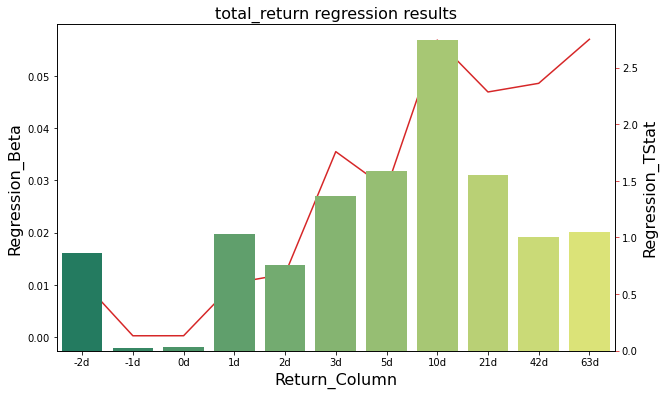

<ipython-input-15-239e6cabfee6>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf['Return_Column'] = tempdf['Return_Column'].apply(lambda x: int(x.split('_')[-1].replace('d','')))


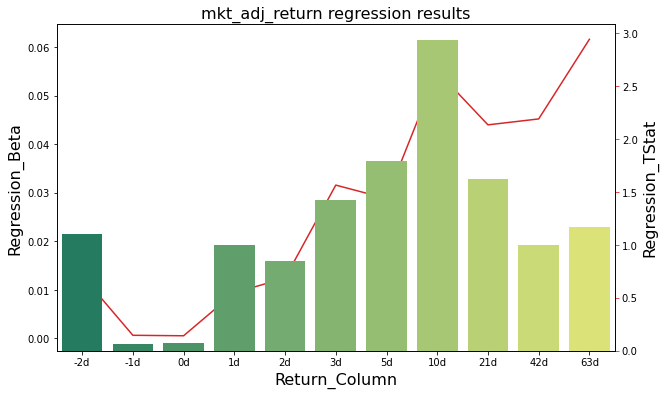

<ipython-input-15-239e6cabfee6>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf['Return_Column'] = tempdf['Return_Column'].apply(lambda x: int(x.split('_')[-1].replace('d','')))


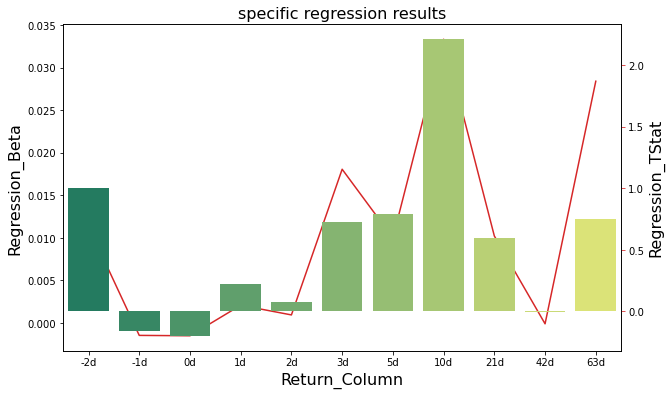

In [27]:
form_regression = render_run_regression_form({})

In [28]:
pre_reg = pd.read_csv("pre_regression_data.csv")
pre_reg.describe()

,sqrt_adv,Growth,Profit,mkt_adj_return_-2d,total_return_-2d,specific_-2d,mkt_adj_return_-1d,total_return_-1d,specific_-1d,mkt_adj_return_0d,...,mkt_adj_return_21d,total_return_21d,specific_21d,mkt_adj_return_42d,total_return_42d,specific_42d,mkt_adj_return_63d,total_return_63d,specific_63d,Profit_delta
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,...,200.000000,200.000000,200.000000,195.000000,195.000000,195.000000,139.000000,139.000000,139.000000,206.000000
mean,4757.390607,-0.167902,-0.750183,-0.029017,-0.031612,-0.014613,-0.016109,-0.015697,-0.011415,-0.006248,...,-0.076848,-0.082267,-0.028781,0.027476,0.042419,-0.022129,-0.019333,0.001131,-0.047518,1.613068
std,6009.400841,1.358733,1.350850,0.130949,0.140952,0.120792,0.109753,0.112044,0.098688,0.093321,...,0.289374,0.315334,0.196893,0.498785,0.510072,0.422775,0.512640,0.477050,0.394232,0.734746
min,227.195951,-3.697520,-3.388510,-0.832389,-0.828800,-0.841168,-0.837517,-0.834400,-0.828503,-0.455787,...,-0.751048,-0.860432,-0.652170,-0.798233,-0.845324,-1.124735,-0.748566,-0.865827,-1.098844,1.002832
25%,1508.073525,-0.978104,-1.701402,-0.083687,-0.094903,-0.055368,-0.047923,-0.049941,-0.043951,-0.045730,...,-0.293253,-0.326508,-0.117082,-0.292156,-0.302350,-0.189624,-0.310484,-0.292514,-0.206662,1.155808
50%,2886.519685,-0.162414,-0.604187,-0.016640,-0.016988,-0.008489,-0.001524,-0.000000,-0.003254,-0.001521,...,-0.063786,-0.054823,-0.022814,-0.023588,-0.018927,-0.057859,-0.080385,-0.039653,-0.082702,1.360504
75%,5625.262985,0.768027,0.195708,0.028025,0.029230,0.038320,0.030456,0.031436,0.022856,0.031413,...,0.123994,0.176548,0.065136,0.240200,0.261940,0.070142,0.163914,0.214741,0.023685,1.851590
max,53463.445456,3.684730,2.342230,0.592367,0.585526,0.548948,0.278078,0.275000,0.265094,0.385191,...,0.772012,0.616924,1.060846,3.322136,3.137254,3.899731,3.210161,2.313725,2.823927,5.343020


In [29]:
reg_results = pd.read_csv("regression_results.csv")
reg_results.describe()

,Regression_Beta,Regression_TStat
count,33.000000,33.000000
mean,0.021835,0.940972
std,0.020450,0.780355
min,-0.001518,-0.197857
25%,0.002068,0.222177
50%,0.012434,0.994062
75%,0.035524,1.368304
max,0.061583,2.936950
